In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

In [97]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%load_ext autoreload
%autoreload 2

from dataloader import get_single_hits
from sklearn.model_selection import train_test_split

from scipy import constants

import gc


#import eli5
#from eli5.sklearn import PermutationImportance

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
tf.test.is_gpu_available()

True

In [47]:
labels = ['x', 'y', 'z', 'time', 'azimuth','zenith', 'energy']

In [82]:
hits, charges, params = get_single_hits('../test_data/oscNext_genie_level3_v01.03_pass2.120000.000000.hdf5', labels=labels)

 79%|███████▊  | 78624/100000 [00:03<00:01, 20027.23it/s]


In [ ]:
hits_list = []
charges_list = []
params_list = []

for i in range(10):
    #fname = '../test_data/oscNext_genie_level3_v01.03_pass2.120000.000%s0.hdf5'%('%s'%i).zfill(2)
    fname = '../test_data/oscNext_genie_level3_v01.03_pass2.140000.000%s00.hdf5'%i
    try:
        hits, charges, params = get_single_hits(
            fname,
            labels = labels,
            )
        hits_list.append(hits)
        charges_list.append(charges)
        params_list.append(params)
    except OSError:
        print('Skipping file %s'%fname)
        #raise Exception

hits = np.concatenate(hits_list)
charges = np.concatenate(charges_list)
params = np.concatenate(params_list)



  0%|          | 0/406784 [00:00<?, ?it/s]

Skipping file ../test_data/oscNext_genie_level3_v01.03_pass2.140000.000000.hdf5


 41%|████      | 167377/406784 [00:18<00:10, 22028.33it/s]

In [168]:
hits_train, hits_test, charges_train, charges_test, params_train, params_test = train_test_split(hits, charges, params, test_size=0.1, random_state=42)

In [169]:
azimuth_idx = labels.index('azimuth')
zenith_idx = labels.index('zenith')
time_idx = labels.index('time')
x_idx = labels.index('x')
y_idx = labels.index('y')
z_idx = labels.index('z')
energy_idx = labels.index('energy')

c = constants.c * 1e-9 # c in m / ns

class trafo(tf.keras.layers.Layer):

    def call(self, hit, params):
        
        dir_x = tf.math.sin(params[:, zenith_idx]) * tf.math.cos(params[:, azimuth_idx])
        dir_y = tf.math.sin(params[:, zenith_idx]) * tf.math.sin(params[:, azimuth_idx])
        dir_z = tf.math.cos(params[:, zenith_idx])
        
        d_time = hit[:,3] - params[:, time_idx]
        d_x = hit[:,0] - params[:, x_idx]
        d_y = hit[:,1] - params[:, y_idx]
        d_z = hit[:,2] - params[:, z_idx]
        
        dist = tf.math.sqrt(tf.math.square(d_x) + tf.math.square(d_y) + tf.math.square(d_z))
        
        # difference c*t - r
        delta = d_time * c - dist

        energy = params[:, energy_idx]
        
        out = tf.concat([hit[:, 0:3], delta[:, tf.newaxis], dist[:, tf.newaxis], dir_x[:, tf.newaxis], dir_y[:, tf.newaxis], dir_z[:, tf.newaxis], energy[:, tf.newaxis]], axis=1)
                
        return out

In [170]:
class LossHistory(tf.keras.callbacks.Callback):
    def __init__(self):
        self.train_losses = []
        self.test_losses = []

    def on_train_batch_end(self, batch, logs={}):
        self.train_losses.append(logs.get('loss'))
        
    def on_test_batch_end(self, batch, logs={}):
        self.test_losses.append(logs.get('loss'))
   

In [184]:
activation='relu'


hits_input = tf.keras.Input(shape=(4,))
params_input = tf.keras.Input(shape=(len(labels),))
t = trafo()

h = t(hits_input, params_input)
h = tf.keras.layers.Dense(32, activation="relu")(h)
h = tf.keras.layers.Dense(64, activation="relu")(h)
h = tf.keras.layers.Dense(128, activation="relu")(h)
h = tf.keras.layers.Dense(64, activation="relu")(h)
h = tf.keras.layers.Dense(32, activation="relu")(h)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(h)


model = tf.keras.Model(inputs=[hits_input, params_input], outputs=outputs)


model.summary()

my_history = LossHistory()


loss_history = []
val_loss_history = []

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 4)]          0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 7)]          0                                            
__________________________________________________________________________________________________
trafo_10 (trafo)                (None, 9)            0           input_19[0][0]                   
__________________________________________________________________________________________________
dense_36 (Dense)                (None, 32)           320         trafo_10[0][0]                   
____________________________________________________________________________________________

In [186]:
optimizer = tf.keras.optimizers.Adam(0.0005)

model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [187]:
def shuffle(hits, params):
    shuffled_hits = np.vstack([hits, hits])
    shuffled_params = np.vstack([params, np.random.permutation(params)])
    target = np.concatenate([np.ones(hits.shape[0]), np.zeros(hits.shape[0])])
    return shuffled_hits, shuffled_params, target

Epoch 21
Train on 1507012 samples, validate on 167446 samples
1507012/1507012 [==============================] - 2s 2us/sample - loss: 0.3677 - val_loss: 0.3666
Epoch 22
Train on 1507012 samples, validate on 167446 samples
1507012/1507012 [==============================] - 3s 2us/sample - loss: 0.3673 - val_loss: 0.3674
Epoch 23
Train on 1507012 samples, validate on 167446 samples
1507012/1507012 [==============================] - 3s 2us/sample - loss: 0.3670 - val_loss: 0.3656
Epoch 24
Train on 1507012 samples, validate on 167446 samples
1507012/1507012 [==============================] - 3s 2us/sample - loss: 0.3664 - val_loss: 0.3664
Epoch 25
Train on 1507012 samples, validate on 167446 samples
1507012/1507012 [==============================] - 3s 2us/sample - loss: 0.3655 - val_loss: 0.3658
Epoch 26
Train on 1507012 samples, validate on 167446 samples
1507012/1507012 [==============================] - 3s 2us/sample - loss: 0.3641 - val_loss: 0.3629
Epoch 27
Train on 1507012 samples,

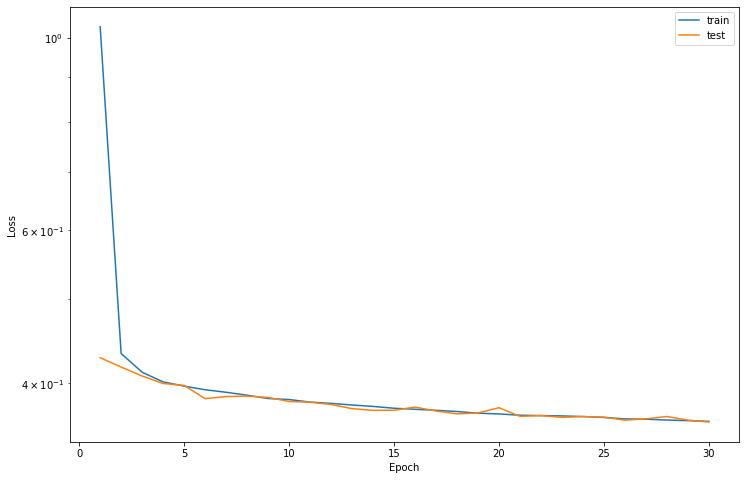

In [219]:
for i in range(10):
    
    shuffled_hits_train, shuffled_params_train, outputs_train = shuffle(hits_train, params_train)
    shuffled_hits_test, shuffled_params_test, outputs_test = shuffle(hits_test, params_test)
    
    gc.collect()

    print('Epoch %i'%(len(loss_history)+1))
    
    model.fit([shuffled_hits_train, shuffled_params_train], outputs_train, batch_size=2048, epochs=1, validation_data=([shuffled_hits_test, shuffled_params_test], outputs_test), callbacks=[my_history,])

    loss_history.append(model.history.history['loss'])
    val_loss_history.append(model.history.history['val_loss'])
    

fig, ax = plt.subplots(1, 1, figsize=(12,8))
x = np.arange(1, len(loss_history)+1)
ax.plot(x, np.concatenate(loss_history), label='train')
ax.plot(x, np.concatenate(val_loss_history), label='test')
ax.set_yscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()


In [233]:
hit_idx = 55 #332 #5697

true_params = params_test[hit_idx]
true_hit = hits_test[hit_idx]

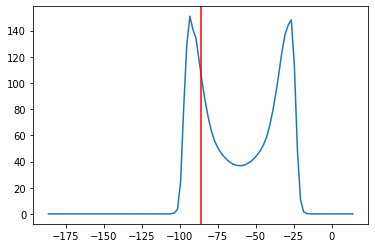

In [237]:
plot_dim = 'y'
plot_idx = labels.index(plot_dim)

true_p = true_params[plot_idx]

#xs = np.linspace(0, np.pi, 100)
xs = np.linspace(true_p-100, true_p+100, 100)

params = np.repeat(true_params, xs.shape[0]).reshape(-1, xs.shape[0]).T
hits = np.repeat(true_hit, xs.shape[0]).reshape(-1, xs.shape[0]).T

params[:, plot_idx] = xs

likelihood = model.predict([hits, params], batch_size=512)

likelihood /= 1 - likelihood

plt.plot(xs, likelihood)
plt.axvline(true_p, c='r')


In [235]:
true_hit

array([ 113.19,  -60.47, -336.31, 9899.  ], dtype=float32)